In [1]:
import os
import re
import csv
from lib_log_parse import load_parsed_logs, parse
from typing import List, Optional
import numpy as np
from lib_constants import log_no_to_region
from model_publication import Publication
from model_retrieval import Retrieval
import multiprocessing as mp
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_theme()

In [2]:
def cdf(series: pd.Series) -> pd.DataFrame:
    return pd.DataFrame.from_dict({
        series.name: np.append(series.sort_values(), series.max()),
        "cdf": np.linspace(0, 1, len(series) + 1)
    })

In [3]:
times = []
with open('../data/adins-script-find-times.csv') as csvfile:
     rows = csv.reader(csvfile, delimiter=',')
     for row in rows:
         times += [float(row[1])]
times = cdf(pd.Series(times, name="durations"))

In [4]:
log_paths = [
    "../data/2023-01-16_gala_nodes",
    "../data/2023-01-24_ignore_gala",
    "../data/2023-01-26_alpha_20"
]

In [5]:
for path in log_paths:
    values = []
    for fn in os.listdir(path):
        file_path = os.path.join(path, fn)
        if not os.path.isfile(file_path):
            continue

        if not fn.endswith(".log"):
            continue

        if os.path.exists(file_path + ".p"):
            print(f"Skipping: {file_path}")
            continue

        values += [[file_path]]

    with mp.Pool() as pool:
        pool.map(parse, values)

Parsing ../data/2023-01-16_gala_nodes/gala-node-2.log
Resetting retrieval for QmagGiaAjhjnEY82MYGNTPbNgKNvkeSG6QUb5J7JN2maWp
Resetting retrieval for QmZGWJwNjBb7rMVCNKafa5YgJc22tYoFcnUi2t9sCfvnih
Resetting retrieval for QmP3SMZBTQXyZjNNZpQzKYPH9BGjW2SCqeBZqyo94UtE4p
Resetting retrieval for QmSAQmJ7nQgFQdAX4x4zz2xakfRow2EapHuarfFk9gbdrQ
Resetting retrieval for QmU6FDZk3kVPqhJ9Re7odxVTqYLZHB1t5zepUiy3pC2agh
Resetting retrieval for QmRkqWMrBT1F2Hyf7WgFiJYzEWDBRWgoGamtqUBXSFVusB
Resetting retrieval for QmXDWYnPG8S544mxj2QBbZmmb6hqKhw5Dhi1KRBcBDxCAs
Resetting retrieval for QmbeBP3agHqvCa9iSSoAmjW4pJNjJTKhV7tJeZrs8vWWLF
Resetting retrieval for Qmb6bGfwQj9fxzBjsmyvLpdMpe4f9QNKzmoz33SZpaUoUo
Resetting retrieval for QmbCKsCotuK4kSU6oo4ntcEAp3oV4S7nm1nyanvKvgoBHb
Resetting retrieval for QmRVZdDFZvF6YB3qXrxpqXQvoZqd3PdodxDhpUyqLZJQK4
Resetting retrieval for QmPFtroHoXt8raUkaxHA9UHFQ3KpWXmEbSjpGp76nwf2dk
Resetting retrieval for QmbRQjPdGy4ohFxCbtm1XUduomBwPp7aCkt6EEkhXJjpU8
Resetting retrieval for

In [6]:
results_map = {}
files_map = {}
for i, path in enumerate(log_paths):
    files = []
    for fn in os.listdir(path):
        file_path = os.path.join(path, fn)
        if not os.path.isfile(file_path):
            continue

        if not fn.endswith(".log"):
            continue

        files += [file_path]

    pool = mp.Pool(mp.cpu_count())
    results = pool.map(load_parsed_logs, list(map(lambda x: [x], files)))
    if i == 0:
        results_map["with_gala"] = results
        files_map["with_gala"] = files
    elif i == 1:
        results_map["without_gala"] = results
        files_map["without_gala"] = files
    else:
        results_map["alpha_20"] = results
        files_map["alpha_20"] = files


log_files ['../data/2023-01-16_gala_nodes/gala-node-1.log']
Loading  ../data/2023-01-16_gala_nodes/gala-node-1.log
Took 0:00:07.744047
log_files ['../data/2023-01-16_gala_nodes/gala-node-5.log']
Loading  ../data/2023-01-16_gala_nodes/gala-node-5.log
Took 0:00:09.664256
log_files ['../data/2023-01-16_gala_nodes/gala-node-4.log']
Loading  ../data/2023-01-16_gala_nodes/gala-node-4.log
Took 0:00:08.938807
log_files ['../data/2023-01-16_gala_nodes/gala-node-2.log']
Loading  ../data/2023-01-16_gala_nodes/gala-node-2.log
Took 0:00:09.188116
log_files ['../data/2023-01-16_gala_nodes/gala-node-0.log']
Loading  ../data/2023-01-16_gala_nodes/gala-node-0.log
Took 0:00:09.267640
log_files ['../data/2023-01-16_gala_nodes/gala-node-3.log']
Loading  ../data/2023-01-16_gala_nodes/gala-node-3.log
Took 0:00:10.368319
log_files ['../data/2023-01-24_ignore_gala/ignore-gala-node-0.log']
Loading  ../data/2023-01-24_ignore_gala/ignore-gala-node-0.log
Took 0:00:03.410810
log_files ['../data/2023-01-24_ignore_g

In [7]:
def log_origin(origin: str) -> Optional[int]:
    match = re.search(r".*\/gala-node-(\d).log", origin)
    if match is None:
        match = re.search(r".*\/ignore-gala-node-(\d).log", origin)
        if match is None:
            match = re.search(r".*\/alpha-20-node-(\d).log", origin)
            if match is None:
                return None

    return int(match.group(1))

def region_from_origin(origin: str) -> str:
    node = log_origin(origin)
    return log_no_to_region[node]


results_by_region_map = {}

for key, files in files_map.items():
    results_by_region_map[key] = {}
    for idx, f in enumerate(files):
        region = region_from_origin(f)

        if not region in results_by_region_map[key]:
            results_by_region_map[key][region] = []
        results_by_region_map[key][region] += [results_map[key][idx][0]]

In [8]:
df_retrievals_dict_map ={}
df_publications_dict_map ={}
for key, files in files_map.items():
    df_publications_dict_map[key] = {
        "total_publication_duration": []
    }
    df_retrievals_dict_map[key] = {
        "node": [],
        "region": [],
        "started_at": [],
        "overall_retrieval_duration": [],
        "dht_walks_duration": [],
        "find_first_provider_duration": [],
        "connected_duration": [],
        "received_first_HAVE_duration": [],
        "content_fetch_duration": [],
        "find_provider_queries_count": [],
        "has_error": [],
    }
    publications: List[Publication] = []
    retrievals: List[Retrieval] = []
    for parsed_log in results_map[key]:
        for log in parsed_log:
            publications += log.publications
            retrievals += log.retrievals

    # Remove all retrievals that are marked as invalid
    retrievals = list(
        filter(lambda ret: not ret.marked_as_incomplete, retrievals))
    retrievals = list(filter(lambda ret: ret.state != Retrieval.State.DONE_WITHOUT_ASKING_PEERS, retrievals))

    for pub in publications:
        try:
            df_publications_dict_map[key]["total_publication_duration"] += [pub.duration_total_publication().total_seconds()]
        except:
            print("AAH")
            continue

    for ret in retrievals:
        if ret.stream_opened_at is None or ret.connected_at is None:
            print("skip", ret.stream_opened_at, ret.connected_at)
            continue

        node = log_origin(ret.origin)
        region = region_from_origin(ret.origin)
        # region = region_from_origin(ret.origin)
        if region is None:
            raise Exception("AHH")

        df_retrievals_dict_map[key]["started_at"] += [ret.dial_started_at]
        df_retrievals_dict_map[key]["node"] += [node]
        df_retrievals_dict_map[key]["region"] += [region]
        df_retrievals_dict_map[key]["has_error"] += [ret.done_retrieving_error is not None]

        overall_retrieval_duration = (ret.done_retrieving_at - ret.retrieval_started_at).total_seconds()
        # simulate peer record retrieval by adding the DHT walk duration
        overall_retrieval_duration += ret.get_dht_walk_duration()
        df_retrievals_dict_map[key]["overall_retrieval_duration"] += [overall_retrieval_duration]

        # simulate peer record retrieval by adding the DHT walk duration
        dht_walks_duration = 2 * ret.get_dht_walk_duration()
        df_retrievals_dict_map[key]["dht_walks_duration"] += [dht_walks_duration]

        df_retrievals_dict_map[key]["find_first_provider_duration"] += [(
                                                                       ret.found_first_provider_at - ret.get_providers_queries_started_at).total_seconds()]
        df_retrievals_dict_map[key]["content_fetch_duration"] += [(ret.done_retrieving_at - ret.dial_started_at).total_seconds()]
        df_retrievals_dict_map[key]["find_provider_queries_count"] += [
            len(list(filter(lambda gpq: gpq.started_at > ret.done_retrieving_at, ret.get_providers_queries.values())))]
        df_retrievals_dict_map[key]["connected_duration"] += [(ret.connected_at - ret.get_providers_queries_started_at).total_seconds()]
        df_retrievals_dict_map[key]["received_first_HAVE_duration"] += [(ret.received_first_HAVE_at - ret.get_providers_queries_started_at).total_seconds()]

    # df_retrievals = pd.DataFrame.from_dict(df_retrievals_dict_map[key])

AAH
AAH
AAH
AAH
AAH
skip None 2023-01-16 21:33:22.442178+00:00
skip None 2023-01-18 05:38:55.063671+00:00
skip None 2023-01-21 01:18:53.829067+00:00
skip None 2023-01-25 07:55:45.124441+00:00
skip None 2023-01-17 06:19:01.241034+00:00
skip None 2023-01-18 04:43:30.621306+00:00
skip None 2023-01-18 05:36:15.018519+00:00
skip None 2023-01-19 13:57:59.333363+00:00
skip None 2023-01-17 06:19:00.369913+00:00
skip None 2023-01-25 06:59:08.984240+00:00
skip None 2023-01-18 04:43:29.973701+00:00
skip None 2023-01-19 08:40:57.815826+00:00
skip None 2023-01-27 01:10:17.059472+00:00
skip None 2023-01-27 01:01:35.178752+00:00
skip None 2023-01-25 11:40:01.632524+00:00
skip None 2023-01-27 07:45:00.610202+00:00
skip None 2023-01-25 04:12:29.128173+00:00
AAH
AAH
AAH
AAH


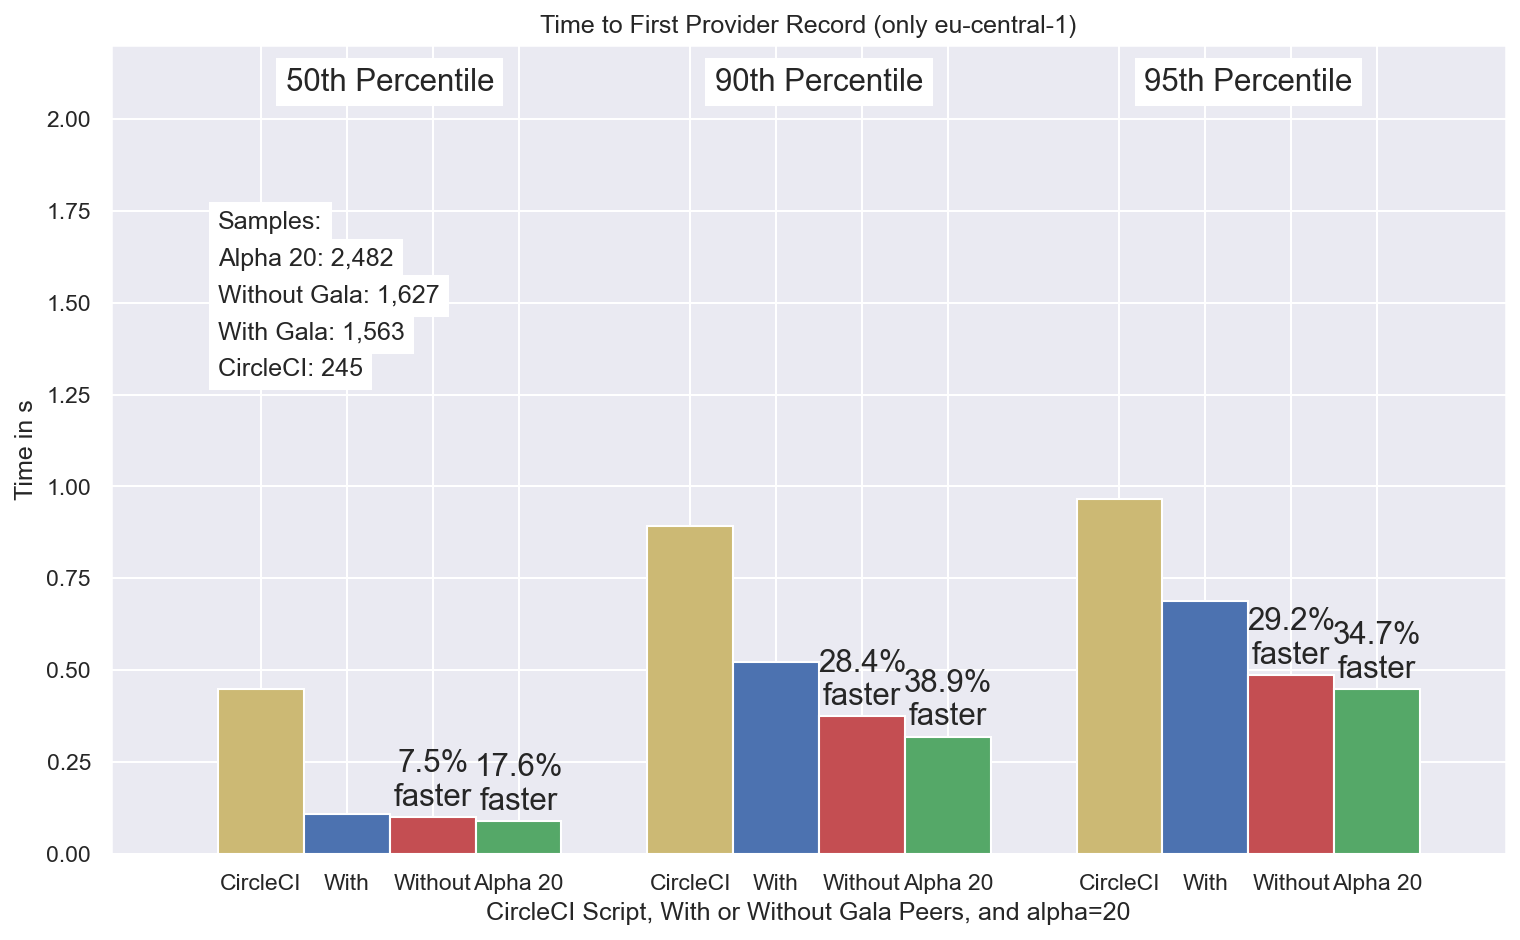

In [9]:
width = 0.2

fig, ax = plt.subplots(figsize=[12, 7], dpi=150)

xticks = []
labels = []
retrievals_by_galas = {
    "with": pd.DataFrame.from_dict(df_retrievals_dict_map["with_gala"]),
    "without": pd.DataFrame.from_dict(df_retrievals_dict_map["without_gala"]),
    "alpha_20": pd.DataFrame.from_dict(df_retrievals_dict_map["alpha_20"]),
}
min_date = retrievals_by_galas["alpha_20"]["started_at"].min()
region = "eu_central_1"
sample_counts = {}
for i, percentile in enumerate([50, 90, 95]):

    sample_counts["CircleCI"] = len(times)
    circleci_percentile = np.percentile(times, percentile)
    ax.bar(i - 2 * width, circleci_percentile, width, label="CircleCI", color="y")

    dat = retrievals_by_galas["with"]
    dat = dat[dat["region"] == region]
    dat = dat[dat["started_at"] >= min_date]
    dat = dat["find_first_provider_duration"]
    sample_counts["With Gala"] = len(dat)
    with_percentile = np.percentile(dat, percentile)
    ax.bar(i - width, with_percentile, width, label="With Galas", color="b")

    dat = retrievals_by_galas["without"]
    dat = dat[dat["region"] == region]
    dat = dat[dat["started_at"] >= min_date]
    dat = dat["find_first_provider_duration"]
    sample_counts["Without Gala"] = len(dat)
    without_percentile = np.percentile(dat, percentile)
    ax.bar(i, without_percentile, width, label="Without Galas", color="r")

    dat = retrievals_by_galas["alpha_20"]
    dat = dat[dat["region"] == region]
    dat = dat[dat["started_at"] >= min_date]
    dat = dat["find_first_provider_duration"]
    sample_counts["Alpha 20"] = len(dat)
    alpha_20 = np.percentile(dat, percentile)
    ax.bar(i + width, alpha_20, width, label="Alpha 20", color="g")
    ax.text(i, without_percentile + 0.1, f"{1- without_percentile / with_percentile:.1%}\nfaster", ha="center", va="center", size=15)
    ax.text(i + width, alpha_20 + 0.1, f"{1- alpha_20 / with_percentile:.1%}\nfaster", ha="center", va="center", size=15)

    ax.text(i-width/2, 2.1, f"{percentile}th Percentile", ha="center", va="center", size=15,
            bbox=dict(fc="w", lw=1))
    xticks += [i -2*width, i - width, i, i + width]
    labels += ["CircleCI", "With", "Without", "Alpha 20"]

for i, key in enumerate(sample_counts):
    ax.text(-0.5, 0.1*i + 1.3, f"{key}: {format(sample_counts[key], ',')}",bbox=dict(fc="w", lw=1))

ax.text(-0.5, 0.1*4 + 1.3, "Samples:",bbox=dict(fc="w", lw=1))

ax.set_title(f"Time to First Provider Record (only eu-central-1)")
ax.set_xlabel("CircleCI Script, With or Without Gala Peers, and alpha=20")
ax.set_ylabel("Time in s")
ax.set_xticks(xticks, labels)
ax.set_xlim(-0.75, 2.5)
ax.set_ylim(0, 2.2)

ax.set_xticks(xticks, labels)


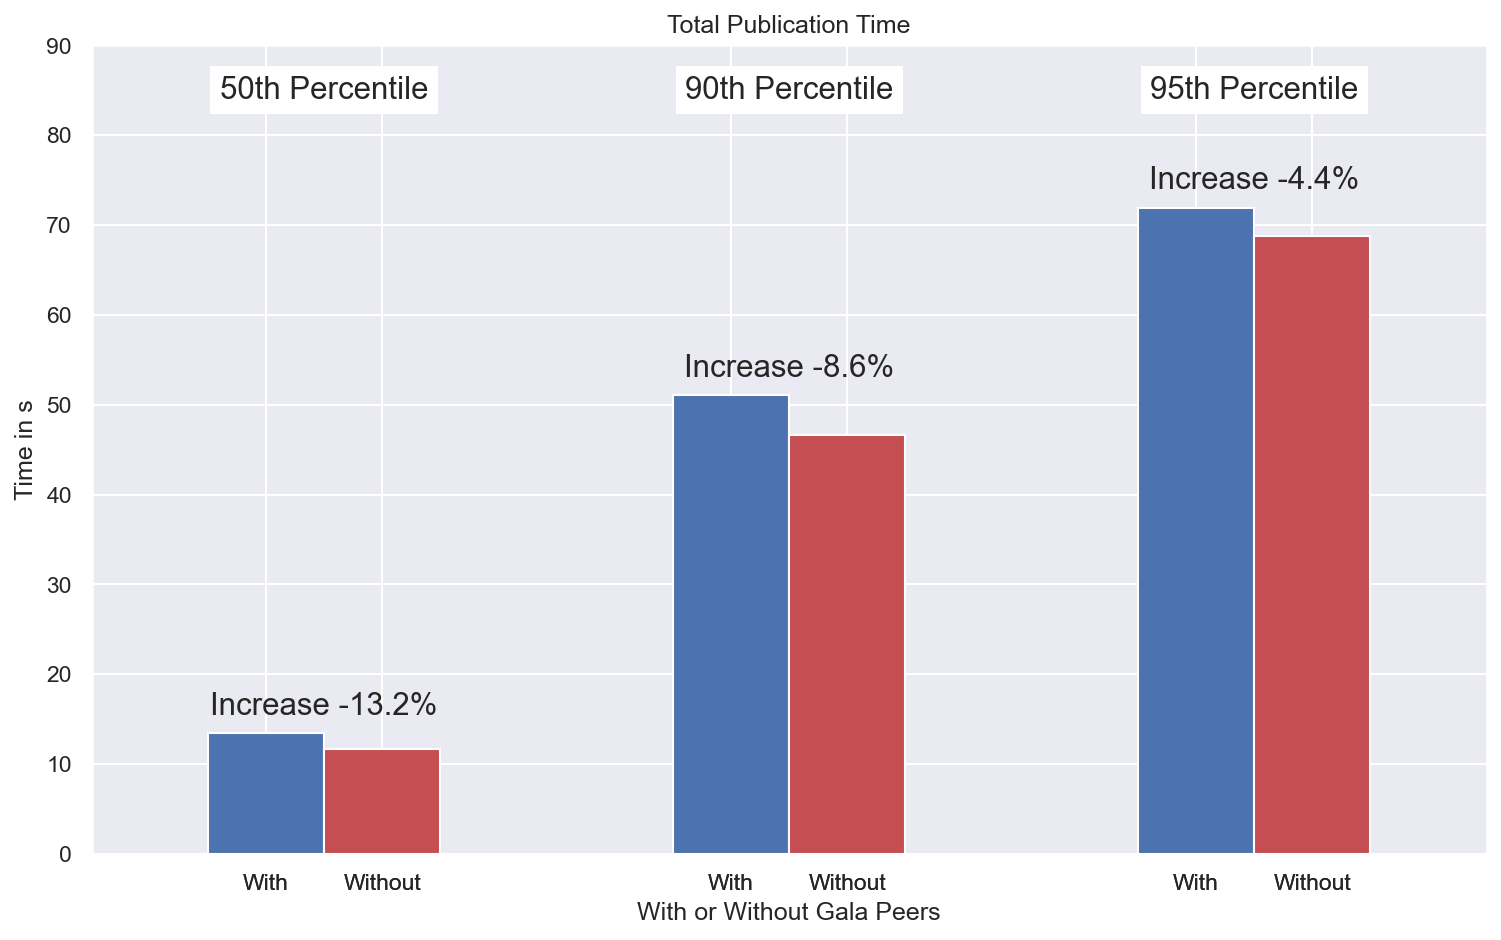

In [10]:
width = 0.25

fig, ax = plt.subplots(figsize=[12, 7], dpi=150)

xticks = []
labels = []
publications_by_galas = {
    "with": pd.DataFrame.from_dict(df_publications_dict_map["with_gala"]),
    "without": pd.DataFrame.from_dict(df_publications_dict_map["without_gala"]),
}
for i, percentile in enumerate([50, 90, 95]):
    dat = publications_by_galas["with"]["total_publication_duration"]
    with_percentile = np.percentile(dat, percentile)
    ax.bar(i - width / 2, with_percentile, width, label="With Galas", color="b")

    dat = publications_by_galas["without"]["total_publication_duration"]
    without_percentile = np.percentile(dat, percentile)
    ax.bar(i + width / 2, without_percentile, width, label="Without Galas", color="r")
    ax.text(i, with_percentile + 3, f"Increase {without_percentile / with_percentile - 1:.1%}", ha="center",
            va="center", size=15)

    ax.text(i, 85, f"{percentile}th Percentile", ha="center", va="center", size=15,
            bbox=dict(fc="w", lw=1))
    xticks += [i - width / 2, i + width / 2]
    labels += ["With", "Without"]


ax.set_title(f"Total Publication Time")
ax.set_xlabel("With or Without Gala Peers")
ax.set_ylabel("Time in s")
ax.set_xticks(xticks, labels)
ax.set_xlim(-0.5, 2.5)
ax.set_ylim(0, 90)

for i in range(3):
    xticks += [i - width / 2, i + width / 2]
    labels += ["With", "Without"]
ax.set_xticks(xticks, labels)
